In [3]:
# imports and setup 
import scipy as sc
from scipy.stats import norm
import glob

import pandas as pd
import numpy as np

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

PART 1

In [4]:
path =r'/Users/westleykirkham/PycharmProjects/Translator/' # use your path

def makeDataFrame(path, filename):
    allFiles = glob.glob(path + filename)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    # Delete columns we won't be using
    nf = frame.drop('font', axis=1)
    nf = nf.drop('fontVariant', axis=1)
    nf = nf.drop('strength', axis=1)
    nf = nf.drop('italic', axis=1)
    nf = nf.drop('orientation', axis=1)
    nf = nf.drop('m_top', axis=1)
    nf = nf.drop('m_left', axis=1)
    nf = nf.drop('originalH', axis=1)
    nf = nf.drop('originalW', axis=1)
    nf = nf.drop('h', axis=1)
    nf = nf.drop('w', axis=1)
    return nf

In [5]:
nf = makeDataFrame(path, "KUNSTLER.csv")

In [8]:
#returns 2 numpy arrays: Xs which is a #samples x 20 x 20 array containing the pixel values, 
#and Ys which is a #samples x 1 array containing the ascii vales for each character. 
#Divides everything in the Xs array by 255 to scale the values from 0-1.
def dfTransform(df):
    Ys = df.iloc[:,:1].values
    Xs = df.iloc[:,1:].values / 255
    return Xs, Ys

In [9]:
X_s, Y_s = dfTransform(nf)

In [10]:
Y_s

array([[61442],
       [61441],
       [ 9674],
       [ 8805],
       [ 8804],
       [ 8800],
       [ 8776],
       [ 8747],
       [ 8734],
       [ 8730],
       [ 8729],
       [ 8725],
       [ 8722],
       [ 8721],
       [ 8719],
       [ 8710],
       [ 8706],
       [ 8486],
       [ 8482],
       [ 8364],
       [ 8250],
       [ 8249],
       [ 8240],
       [ 8230],
       [ 8226],
       [ 8225],
       [ 8224],
       [ 8222],
       [ 8221],
       [ 8220],
       [ 8218],
       [ 8217],
       [ 8216],
       [ 8212],
       [ 8211],
       [  960],
       [  733],
       [  732],
       [  731],
       [  730],
       [  729],
       [  728],
       [  713],
       [  711],
       [  710],
       [  402],
       [  382],
       [  381],
       [  376],
       [  353],
       [  352],
       [  339],
       [  338],
       [  322],
       [  321],
       [  305],
       [  254],
       [  253],
       [  252],
       [  251],
       [  250],
       [  249],
       [

PART 2

In [11]:
# for computing the char_to_ix and ix_to_char arrays. 
# computes those maps given a y vector.
def CharToIxArr(Y):
    char = np.concatenate(Y)
    chars = list(set(char))
    char_to_ix = { ch:i for i,ch in enumerate(char) }
    ix_to_char = { i:ch for i,ch in enumerate(char) }
    char_to_ix = {ch:i for i,ch in enumerate(char_to_ix)}
    return char_to_ix, ix_to_char

In [12]:
char_to_ix, ix_to_char = CharToIxArr(Y_s)
char_to_ix

{61442: 0,
 61441: 1,
 9674: 2,
 8805: 3,
 8804: 4,
 8800: 5,
 8776: 6,
 8747: 7,
 8734: 8,
 8730: 9,
 8729: 10,
 8725: 11,
 8722: 12,
 8721: 13,
 8719: 14,
 8710: 15,
 8706: 16,
 8486: 17,
 8482: 18,
 8364: 19,
 8250: 20,
 8249: 21,
 8240: 22,
 8230: 23,
 8226: 24,
 8225: 25,
 8224: 26,
 8222: 27,
 8221: 28,
 8220: 29,
 8218: 30,
 8217: 31,
 8216: 32,
 8212: 33,
 8211: 34,
 960: 35,
 733: 36,
 732: 37,
 731: 38,
 730: 39,
 729: 40,
 728: 41,
 713: 42,
 711: 43,
 710: 44,
 402: 45,
 382: 46,
 381: 47,
 376: 48,
 353: 49,
 352: 50,
 339: 51,
 338: 52,
 322: 53,
 321: 54,
 305: 55,
 254: 56,
 253: 57,
 252: 58,
 251: 59,
 250: 60,
 249: 61,
 248: 62,
 247: 63,
 246: 64,
 245: 65,
 244: 66,
 243: 67,
 242: 68,
 241: 69,
 240: 70,
 239: 71,
 238: 72,
 237: 73,
 236: 74,
 235: 75,
 234: 76,
 233: 77,
 232: 78,
 231: 79,
 230: 80,
 229: 81,
 228: 82,
 227: 83,
 226: 84,
 225: 85,
 224: 86,
 223: 87,
 222: 88,
 221: 89,
 220: 90,
 219: 91,
 218: 92,
 217: 93,
 216: 94,
 215: 95,
 214: 96,
 21

In [13]:
# Create a one-hot representation
def makeOneHot(char_to_ix, ix_to_char):
    shape = (len(ix_to_char), len(char_to_ix))
    val = 0
    dt = np.int
    a = np.empty(shape,dtype=dt)
    a.fill(val)
    for i in range(len(ix_to_char)):
        ch = ix_to_char[i]
        a[i][char_to_ix[ch]] = 1
    return a
a = makeOneHot(char_to_ix, ix_to_char)

In [14]:
(len(a))

976

PART 3

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
### Junchen helped me extensively with this.
def makeModel(chars):
    model = Sequential([
        Conv2D(32, (4,4), input_shape=(20,20, 1)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (4,4)),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dropout(0.4),
        Dense(64),
        Activation('relu'),
        Dense(len(chars)),
        Activation('softmax'),
    ])
    # For a multi-class classification problem
    model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model
model = makeModel(char_to_ix)

Using TensorFlow backend.


In [16]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(np.reshape(X_s,(-1,20,20,1)), a, epochs=100, batch_size=32)

Epoch 1/100
976/976 [==============================] - 1s 582us/step - loss: 5.5062 - acc: 0.0031
Epoch 2/100
976/976 [==============================] - 0s 280us/step - loss: 5.4415 - acc: 0.0133
Epoch 3/100
976/976 [==============================] - 0s 256us/step - loss: 5.2392 - acc: 0.0205
Epoch 4/100
976/976 [==============================] - 0s 254us/step - loss: 4.9361 - acc: 0.0256
Epoch 5/100
976/976 [==============================] - 0s 256us/step - loss: 4.5553 - acc: 0.0461
Epoch 6/100
976/976 [==============================] - 0s 260us/step - loss: 4.1102 - acc: 0.0932
Epoch 7/100
976/976 [==============================] - 0s 272us/step - loss: 3.7185 - acc: 0.1219
Epoch 8/100
976/976 [==============================] - 0s 298us/step - loss: 3.3698 - acc: 0.1742
Epoch 9/100
976/976 [==============================] - 0s 272us/step - loss: 3.0620 - acc: 0.2223
Epoch 10/100
976/976 [==============================] - 0s 296us/step - loss: 2.7879 - acc: 0.2336
Epoch 11/100
976/97

PART 4

In [17]:
x_train, x_test, a_train, a_test = train_test_split(X_s, a, train_size = 0.8, test_size = 0.2)

In [18]:
#make new model and test it using cross validation
model2 = makeModel(char_to_ix)
model2.fit(np.reshape(x_train, (-1,20,20,1)), a_train, epochs = 100, batch_size=32)

Epoch 1/100
780/780 [==============================] - 0s 576us/step - loss: 5.5088 - acc: 0.0051
Epoch 2/100
780/780 [==============================] - 0s 251us/step - loss: 5.4757 - acc: 0.0064
Epoch 3/100
780/780 [==============================] - 0s 257us/step - loss: 5.3982 - acc: 0.0115
Epoch 4/100
780/780 [==============================] - 0s 264us/step - loss: 5.1829 - acc: 0.0256
Epoch 5/100
780/780 [==============================] - 0s 255us/step - loss: 4.9158 - acc: 0.0346
Epoch 6/100
780/780 [==============================] - 0s 254us/step - loss: 4.5933 - acc: 0.0551
Epoch 7/100
780/780 [==============================] - 0s 251us/step - loss: 4.1867 - acc: 0.0949
Epoch 8/100
780/780 [==============================] - 0s 254us/step - loss: 3.8680 - acc: 0.1372
Epoch 9/100
780/780 [==============================] - 0s 264us/step - loss: 3.4936 - acc: 0.1821
Epoch 10/100
780/780 [==============================] - 0s 254us/step - loss: 3.1619 - acc: 0.2115
Epoch 11/100
780/78

In [19]:
model2.evaluate(np.reshape(x_test, (-1,20,20,1)), a_test)

196/196 [==============================] - 0s 427us/step


[2.033448649912464, 0.5714285714285714]

***The model is about ranges from about 55% to 62% accurate, averaging around 59% accurate.***

In [20]:
# Create and train a different network topology
# Try to find a topology that works better than the one described above.
def makeImprovedModel(chars):
    model = Sequential()
    model.add(Conv2D(32, (4,4), input_shape=(20,20, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.5))
    model.add(Conv2D(64, (2,2), input_shape=(20,20,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(SpatialDropout2D(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(chars), activation='softmax'))
    # For a multi-class classification problem
    model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model
model3 = makeImprovedModel(char_to_ix)

In [21]:
model3.fit(np.reshape(x_train, (-1,20,20,1)), a_train, epochs = 100, batch_size=32)
model3.evaluate(np.reshape(x_test, (-1,20,20,1)), a_test)

Epoch 1/100
780/780 [==============================] - 1s 881us/step - loss: 5.5118 - acc: 0.0026
Epoch 2/100
780/780 [==============================] - 0s 457us/step - loss: 5.4705 - acc: 0.0077
Epoch 3/100
780/780 [==============================] - 0s 380us/step - loss: 5.4282 - acc: 0.0077
Epoch 4/100
780/780 [==============================] - 0s 440us/step - loss: 5.3489 - acc: 0.0141
Epoch 5/100
780/780 [==============================] - 0s 450us/step - loss: 5.1697 - acc: 0.0282
Epoch 6/100
780/780 [==============================] - 0s 405us/step - loss: 4.9245 - acc: 0.0577
Epoch 7/100
780/780 [==============================] - 0s 396us/step - loss: 4.6111 - acc: 0.0808
Epoch 8/100
780/780 [==============================] - 0s 467us/step - loss: 4.2389 - acc: 0.1359
Epoch 9/100
780/780 [==============================] - 0s 389us/step - loss: 3.8599 - acc: 0.1808
Epoch 10/100
780/780 [==============================] - 0s 354us/step - loss: 3.4125 - acc: 0.2333
Epoch 11/100
780/78

[1.747477234626303, 0.6581632653061225]

***I was able to get 65-69% accuracy (averaging 67%, about 8% better) by increasing the number of layers, changing the second convolution layer, increasing the initial dropout from .4 to .5, reducing the pool size of the second maxpool. ***

***New Data Set***

In [6]:
nf2 = makeDataFrame(path, "BANKGOTHIC.csv")

In [25]:
X2_s, Y2_s = dfTransform(nf2)
char2_to_ix2, ix2_to_char2 = CharToIxArr(Y2_s)
b = makeOneHot(char2_to_ix2, ix2_to_char2)
x2_train, x2_test, b_train, b_test = train_test_split(X2_s, b, train_size = 0.8, test_size = 0.2)
model4 = makeImprovedModel(char2_to_ix2)

In [26]:
model4.fit(np.reshape(x2_train, (-1,20,20,1)), b_train, epochs = 100, batch_size=32)
model4.evaluate(np.reshape(x2_test, (-1,20,20,1)), b_test)

Epoch 1/100
1792/1792 [==============================] - 1s 536us/step - loss: 5.6352 - acc: 0.0061
Epoch 2/100
1792/1792 [==============================] - 1s 314us/step - loss: 5.4920 - acc: 0.0173
Epoch 3/100
1792/1792 [==============================] - 1s 319us/step - loss: 4.8109 - acc: 0.0586
Epoch 4/100
1792/1792 [==============================] - 1s 324us/step - loss: 3.7394 - acc: 0.1596
Epoch 5/100
1792/1792 [==============================] - 1s 319us/step - loss: 2.8296 - acc: 0.2701
Epoch 6/100
1792/1792 [==============================] - 1s 319us/step - loss: 2.3833 - acc: 0.3588
Epoch 7/100
1792/1792 [==============================] - 1s 348us/step - loss: 2.0151 - acc: 0.4196
Epoch 8/100
1792/1792 [==============================] - 1s 320us/step - loss: 1.8846 - acc: 0.4392
Epoch 9/100
1792/1792 [==============================] - 1s 314us/step - loss: 1.6610 - acc: 0.5017
Epoch 10/100
1792/1792 [==============================] - 1s 319us/step - loss: 1.5956 - acc: 0.5195

[0.8403047748974392, 0.6785714285714286]

***My network got 61-68% accuracy when trained and tested on BANKGOTHIC, and 18% accuracy when trained on TAHOMA. I had to re-train and retest because testing the model on a new data set doesn't always seem to work. They have differing amounts of unique characters. I believe the difference in accuracy is because TAHOMA has over 3000 characters and BANKGOTHIC has around 300. (similar to KUNSTLER, which I started wtih)***

In [7]:
# Testing with three fonts
nf3 = makeDataFrame(path, "B*.csv")

In [28]:
X3_s, Y3_s = dfTransform(nf3)
char3_to_ix3, ix3_to_char3 = CharToIxArr(Y3_s)
c = makeOneHot(char3_to_ix3, ix3_to_char3)
x3_train, x3_test, c_train, c_test = train_test_split(X3_s, c, train_size = 0.8, test_size = 0.2)
model5 = makeImprovedModel(char3_to_ix3)

In [29]:
model5.fit(np.reshape(x3_train, (-1,20,20,1)), c_train, epochs = 100, batch_size=32)
model5.evaluate(np.reshape(x3_test, (-1,20,20,1)), c_test)

Epoch 1/100
3340/3340 [==============================] - 2s 452us/step - loss: 5.6378 - acc: 0.0066
Epoch 2/100
3340/3340 [==============================] - 1s 363us/step - loss: 5.2407 - acc: 0.0407
Epoch 3/100
3340/3340 [==============================] - 1s 336us/step - loss: 4.0046 - acc: 0.1614
Epoch 4/100
3340/3340 [==============================] - 1s 328us/step - loss: 3.0716 - acc: 0.2743
Epoch 5/100
3340/3340 [==============================] - 1s 316us/step - loss: 2.5295 - acc: 0.3722
Epoch 6/100
3340/3340 [==============================] - 1s 316us/step - loss: 2.2166 - acc: 0.4198
Epoch 7/100
3340/3340 [==============================] - 1s 323us/step - loss: 1.9842 - acc: 0.4584
Epoch 8/100
3340/3340 [==============================] - 1s 328us/step - loss: 1.8207 - acc: 0.4907
Epoch 9/100
3340/3340 [==============================] - 1s 337us/step - loss: 1.6865 - acc: 0.5177
Epoch 10/100
3340/3340 [==============================] - 1s 327us/step - loss: 1.5853 - acc: 0.5344

[1.2417039654471658, 0.6794258373205742]

***I got an accuracy of about 63-67% training and testing my best network on three different fonts. That's about 2% worse than in the 1 font case.***

In [8]:
# Comparing how a model performs when used on a different font from the one it was trained on.
nf4 = makeDataFrame(path, "HARLOW.csv")

In [31]:
X4_s, Y4_s = dfTransform(nf4)
char4_to_ix4, ix4_to_char4 = CharToIxArr(Y4_s)
d = makeOneHot(char4_to_ix4, ix4_to_char4)
x4_train, x4_test, d_train, d_test = train_test_split(X4_s, d, train_size = 0.8, test_size = 0.2)
len(char4_to_ix4)

238

***Since VIVALDI and HARLOW have the same number of characters I'm going to build and train a model on HARLOW then test it on VIVALDI to see how it performs. (when I made char_to_ix arrays they both had a length of 238)***

In [32]:
model6 = makeImprovedModel(char4_to_ix4)
model6.fit(np.reshape(x4_train, (-1,20,20,1)), d_train, epochs = 100, batch_size=32)
model6.evaluate(np.reshape(x4_test, (-1,20,20,1)), d_test)

Epoch 1/100
761/761 [==============================] - 1s 926us/step - loss: 5.4898 - acc: 0.0026
Epoch 2/100
761/761 [==============================] - 0s 344us/step - loss: 5.4604 - acc: 0.0053
Epoch 3/100
761/761 [==============================] - 0s 342us/step - loss: 5.4114 - acc: 0.0184
Epoch 4/100
761/761 [==============================] - 0s 339us/step - loss: 5.2689 - acc: 0.0394
Epoch 5/100
761/761 [==============================] - 0s 337us/step - loss: 4.8995 - acc: 0.0644
Epoch 6/100
761/761 [==============================] - 0s 332us/step - loss: 4.3241 - acc: 0.1380
Epoch 7/100
761/761 [==============================] - 0s 335us/step - loss: 3.6497 - acc: 0.2260
Epoch 8/100
761/761 [==============================] - 0s 350us/step - loss: 2.9634 - acc: 0.3154
Epoch 9/100
761/761 [==============================] - 0s 341us/step - loss: 2.3064 - acc: 0.4455
Epoch 10/100
761/761 [==============================] - 0s 344us/step - loss: 1.9504 - acc: 0.4888
Epoch 11/100
761/76

[0.42757419500675503, 0.9214659688984537]

***I get an excellent fit with the HARLOW data. 88-95% accurate.***

In [9]:
nf5 = makeDataFrame(path, "VIVALDI.csv")

In [34]:
X5_s, Y5_s = dfTransform(nf5)
char5_to_ix5, ix5_to_char5 = CharToIxArr(Y5_s)
e = makeOneHot(char5_to_ix5, ix5_to_char5)
x5_train, x5_test, e_train, e_test = train_test_split(X5_s, e, train_size = 0.8, test_size = 0.2)

In [35]:
model6.evaluate(np.reshape(x5_test, (-1,20,20,1)), e_test)

191/191 [==============================] - 0s 130us/step


[9.853086166981003, 0.10471204141671744]

***The model gets 10-16% accuracy when attempting to predict the VIVALDI characters when trained on the HARLOW characters.***

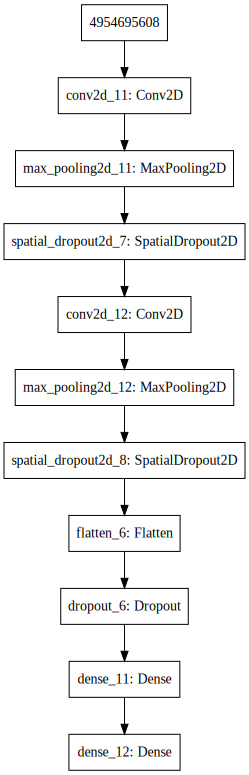

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model6).create(prog='dot', format='svg'))

***That was not what I wanted.***

In [37]:
### Junchen helped me extensively with this as well.
# Display images of misclassified characters.

import matplotlib.pyplot as plt
%matplotlib inline
# First collect the instances and their unicode codes
y_pred = model6.predict(np.reshape(x5_test, (-1,20,20,1)), batch_size=32, verbose = 0, steps = None)
misses = np.zeros(100)
count=0
for i in range(len(y_pred)):
    if(y_pred[i] != e_test[i]).all():
        misses[count] = i
    count+=1
    if(count == 100):
        break
        
plt.figure(figsize = (10,10))
misses

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        0., 14., 15.,  0., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.,  0., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73.,  0., 75., 76.,  0.,
       78., 79., 80., 81.,  0., 83., 84., 85., 86., 87., 88.,  0., 90.,
       91., 92., 93.,  0., 95., 96., 97., 98., 99.])

<Figure size 720x720 with 0 Axes>

/Users/westleykirkham/PycharmProjects/Translator/venv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


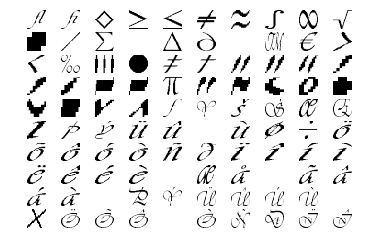

In [38]:
# Plot the characters
for i in misses:
    ii = int(i)
    #print(ii)
    plt.subplot(10,10,ii+1)
    plt.imshow(np.reshape(X5_s[ii], (20,20)), cmap = 'Greys', interpolation='nearest')
    plt.axis('off')
plt.show()

 ***f and capital A are very similar. In many instances, it's the letters or shapes that are close in appearance and form, but have small dots or dashes attached to them that the network misclassifies. Various forms of u with dots and omlauts, quotations, blocky shapes, es, as, os, etc. are all things the network must be unsure of, as they're misclassified together. So, it's essentially guessing between a handful of options when these letters come up because they're too close for it to be able to tell the difference.***